# Building anomaly detector

In [2]:
import pandas as pd
import numpy as np
import pprint
import itertools
import pickle
import datetime as datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, precision_recall_curve,f1_score, fbeta_score, confusion_matrix, roc_curve, log_loss, make_scorer
from sklearn.preprocessing import StandardScaler,PolynomialFeatures

from numpy import mean
from sklearn import svm, model_selection
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_validate

from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, BaggingRegressor
from sklearn.neighbors import KNeighborsClassifier


plt.style.use('ggplot')

%matplotlib inline

In [301]:
pd.set_option('display.max_rows', 22)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True)

In [4]:
df = pd.read_csv("./data/WA_cngstn.csv")

In [5]:
df.head()

,Type,Severity,TMC,StartTime(UTC),EndTime(UTC),LocationLat,LocationLng,Distance(mi),Side,ZipCode,IsAnomaly,Duration
0,3,1,74,2016-11-30 23:35:00,2016-12-01 00:55:09,47.01,-122.91,1.49,-1,98501.00,0,80
1,3,2,73,2016-12-01 00:52:00,2016-12-01 01:04:04,47.61,-122.33,1.49,-1,98104.00,0,12
2,3,1,74,2016-12-01 01:08:00,2016-12-01 01:26:07,47.96,-122.20,2.30,-1,98203.00,0,18
3,3,1,74,2016-12-01 01:02:00,2016-12-01 01:24:00,47.56,-122.19,2.59,-1,98006.00,0,22
4,3,1,74,2016-12-01 01:19:00,2016-12-01 01:31:07,47.62,-122.33,1.64,-1,98101.00,0,12


In [6]:
df

,Type,Severity,TMC,StartTime(UTC),EndTime(UTC),LocationLat,LocationLng,Distance(mi),Side,ZipCode,IsAnomaly,Duration
0,3,1,74,2016-11-30 23:35:00,2016-12-01 00:55:09,47.01,-122.91,1.49,-1,98501.00,0,80
1,3,2,73,2016-12-01 00:52:00,2016-12-01 01:04:04,47.61,-122.33,1.49,-1,98104.00,0,12
2,3,1,74,2016-12-01 01:08:00,2016-12-01 01:26:07,47.96,-122.20,2.30,-1,98203.00,0,18
3,3,1,74,2016-12-01 01:02:00,2016-12-01 01:24:00,47.56,-122.19,2.59,-1,98006.00,0,22
4,3,1,74,2016-12-01 01:19:00,2016-12-01 01:31:07,47.62,-122.33,1.64,-1,98101.00,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...
558776,3,1,74,2017-08-30 21:31:00,2017-08-30 22:13:43,48.84,-122.57,0.30,-1,98248.00,0,43
558777,3,2,73,2017-08-30 22:08:00,2017-08-30 22:49:37,48.60,-118.65,1.75,1,99166.00,0,42
558778,3,3,70,2017-08-30 22:19:00,2017-08-30 23:01:44,49.00,-122.75,0.30,-1,98230.00,1,43
558779,3,3,70,2017-08-30 22:36:00,2017-08-30 23:18:47,49.00,-122.75,0.30,-1,98230.00,1,43


In [7]:
len(df)

558781

In [8]:
df_graph = df.copy()

In [9]:
df_graph['StartTime(UTC)'] = pd.to_datetime(df_graph['StartTime(UTC)'])

In [10]:
dates = df_graph['StartTime(UTC)'].dt.date

In [11]:
df_2017 = df_graph[(dates>pd.Timestamp('2016-12-31').date()) & (dates<pd.Timestamp('2018-01-01'))]

In [12]:
df_2017.describe()

,Type,Severity,TMC,LocationLat,LocationLng,Distance(mi),Side,ZipCode,IsAnomaly,Duration
count,148689.00,148689.00,148689.00,148689.00,148689.00,148689.00,148689.00,148100.00,148689.00,148689.00
mean,3.00,1.78,73.17,47.48,-121.92,3.13,-0.65,98291.57,0.21,47.73
std,0.00,0.77,9.34,0.46,1.04,2.94,0.76,332.36,0.41,40.66
min,3.00,1.00,70.00,45.56,-124.40,0.00,-1.00,98001.00,0.00,10.00
25%,3.00,1.00,72.00,47.28,-122.33,1.26,-1.00,98056.00,0.00,37.00
50%,3.00,2.00,73.00,47.57,-122.26,2.39,-1.00,98144.00,0.00,42.00
75%,3.00,2.00,74.00,47.70,-122.11,3.98,-1.00,98390.00,0.00,49.00
max,3.00,3.00,1601.00,49.00,-117.04,42.35,1.00,99403.00,1.00,950.00


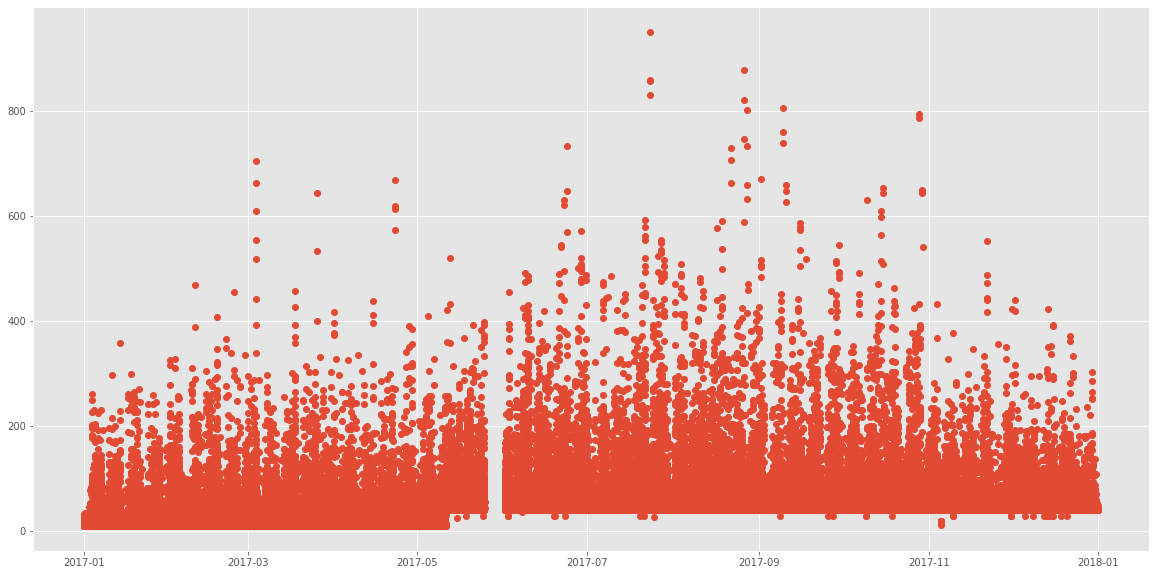

In [13]:
plt.figure(figsize=(20,10))
plt.plot_date(df_2017['StartTime(UTC)'], df_2017['Duration'])

In [14]:
df_2018 = df_graph[(dates>pd.Timestamp('2017-12-31').date()) & (dates<pd.Timestamp('2019-01-01'))]
df_2018.describe()

,Type,Severity,TMC,LocationLat,LocationLng,Distance(mi),Side,ZipCode,IsAnomaly,Duration
count,183388.00,183388.00,183388.00,183388.00,183388.00,183388.00,183388.00,183167.00,183388.00,183388.00
mean,3.00,1.79,73.08,47.53,-122.04,3.13,-0.65,98262.44,0.21,51.29
std,0.00,0.76,4.35,0.49,0.94,2.84,0.76,295.91,0.41,26.08
min,3.00,1.00,70.00,45.56,-124.41,0.00,-1.00,98001.00,0.00,12.00
25%,3.00,1.00,72.00,47.31,-122.33,1.28,-1.00,98055.00,0.00,42.00
50%,3.00,2.00,73.00,47.57,-122.26,2.48,-1.00,98134.00,0.00,43.00
75%,3.00,2.00,74.00,47.75,-122.18,3.98,-1.00,98372.00,0.00,49.00
max,3.00,3.00,1601.00,49.00,-117.04,43.62,1.00,99403.00,1.00,615.00


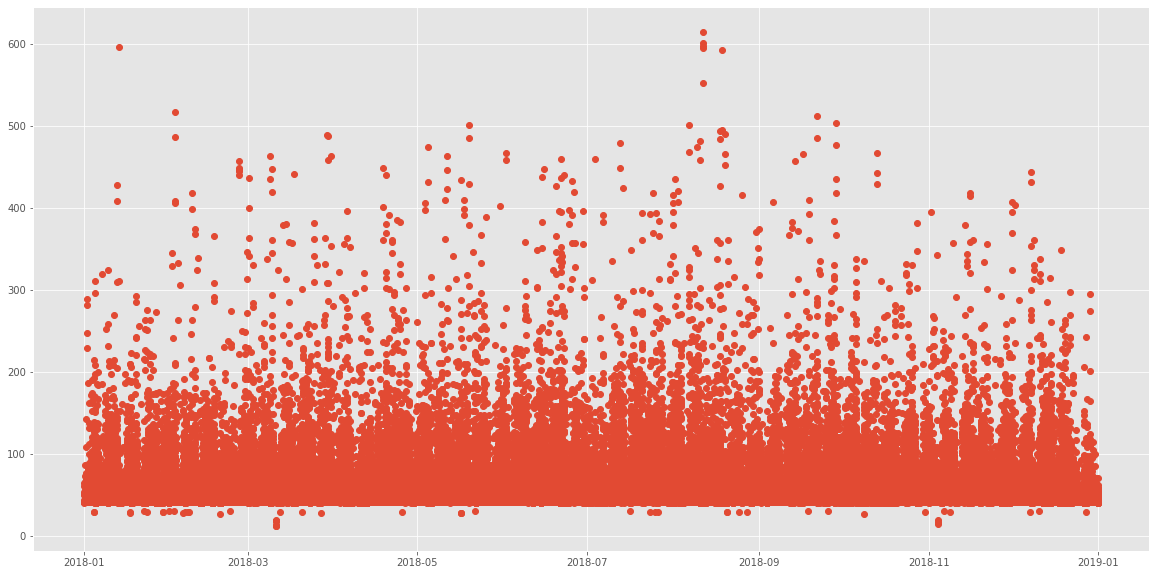

In [15]:
plt.figure(figsize=(20,10))
plt.plot_date(df_2018['StartTime(UTC)'], df_2018['Duration'])

In [16]:
df_2019 = df_graph[(dates>pd.Timestamp('2018-12-31').date()) & (dates<pd.Timestamp('2020-01-01'))]
df_2019.describe()

,Type,Severity,TMC,LocationLat,LocationLng,Distance(mi),Side,ZipCode,IsAnomaly,Duration
count,177082.00,177082.00,177082.00,177082.00,177082.00,177082.00,177082.00,176709.00,177082.00,177082.00
mean,3.00,1.79,73.25,47.45,-121.94,3.44,-0.65,98301.22,0.22,70.74
std,0.00,0.78,6.27,0.51,1.09,3.13,0.76,332.66,0.42,203.38
min,3.00,1.00,70.00,45.56,-124.55,0.00,-1.00,98001.00,0.00,16.00
25%,3.00,1.00,72.00,47.24,-122.33,1.50,-1.00,98055.00,0.00,42.00
50%,3.00,2.00,73.00,47.54,-122.26,2.69,-1.00,98155.00,0.00,49.00
75%,3.00,2.00,75.00,47.70,-122.14,4.28,-1.00,98404.00,0.00,71.00
max,3.00,3.00,1601.00,49.00,-117.04,98.56,1.00,99403.00,1.00,24615.00


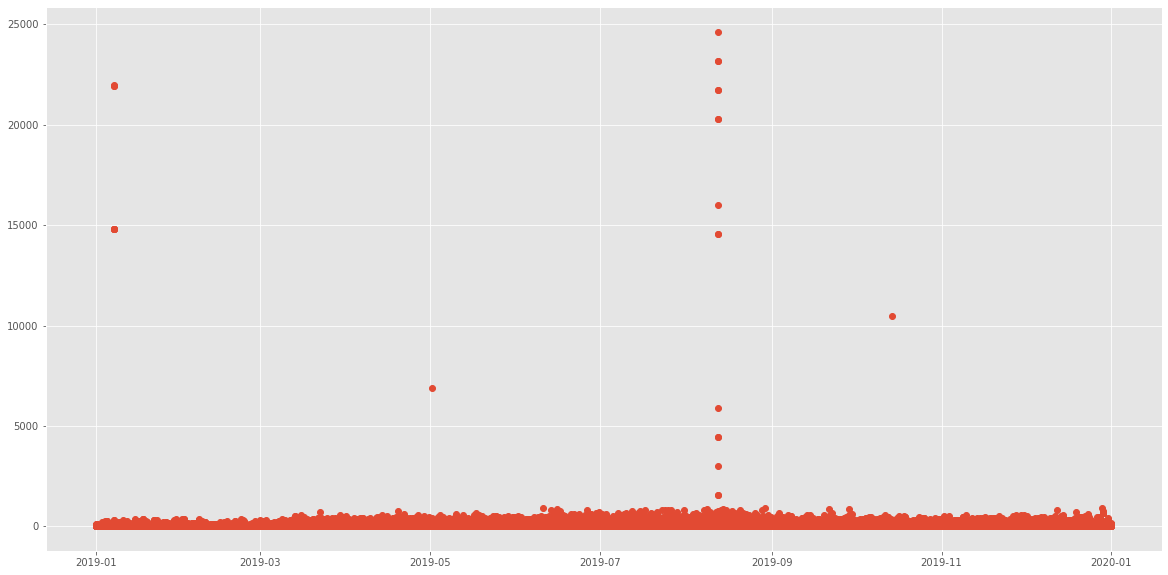

In [17]:
plt.figure(figsize=(20,10))
plt.plot_date(df_2019['StartTime(UTC)'], df_2019['Duration'])

In [18]:
df.IsAnomaly.value_counts()

0    440192
1    118589
Name: IsAnomaly, dtype: int64

In [19]:
df_prune = df.drop(['Type', 'TMC', 'Distance(mi)', 'EndTime(UTC)', 'Side', 'IsAnomaly', 'ZipCode'], axis = 1)
def Mon(x):
    return x.split(" ")[0].split('-')[1]
def Day(x):
    return x.split(" ")[0].split('-')[2]
def Hour(x):
    return x.split(" ")[1].split(':')[0]
def Minute(x):
    return x.split(" ")[1].split(':')[1]
df_prune['StartMonth'] = df_prune['StartTime(UTC)'].apply(lambda x: Mon(x)).astype(int)
df_prune['StartDay'] = df_prune['StartTime(UTC)'].apply(lambda x: Day(x)).astype(int)
df_prune['StartHour'] = df_prune['StartTime(UTC)'].apply(lambda x: Hour(x)).astype(int)
df_prune['StartMinute'] = df_prune['StartTime(UTC)'].apply(lambda x: Minute(x)).astype(int)
df_prune.drop('StartTime(UTC)', inplace=True, axis = 1)
df_prune.isnull().sum().sum()
df_prune.dropna(inplace=True)
df_prune.head()

,Severity,LocationLat,LocationLng,Duration,StartMonth,StartDay,StartHour,StartMinute
0,1,47.01,-122.91,80,11,30,23,35
1,2,47.61,-122.33,12,12,1,0,52
2,1,47.96,-122.20,18,12,1,1,8
3,1,47.56,-122.19,22,12,1,1,2
4,1,47.62,-122.33,12,12,1,1,19


percentile(Duration, CAST(0.95 AS DOUBLE)
123.0

In [20]:
df_prune['IsAnomaly'] = np.where(df_prune['Duration'] >= 123, 1, 0) 

In [21]:
df_prune.head()

,Severity,LocationLat,LocationLng,Duration,StartMonth,StartDay,StartHour,StartMinute,IsAnomaly
0,1,47.01,-122.91,80,11,30,23,35,0
1,2,47.61,-122.33,12,12,1,0,52,0
2,1,47.96,-122.20,18,12,1,1,8,0
3,1,47.56,-122.19,22,12,1,1,2,0
4,1,47.62,-122.33,12,12,1,1,19,0


In [19]:
df_prune.to_csv('./data/WA_pruned.csv', index=False)

In [22]:
df_prune.IsAnomaly.value_counts()

0    530740
1     28041
Name: IsAnomaly, dtype: int64

In [23]:
df_graph = df_prune.copy()

In [24]:
530740/28041

18.927285046895616

In [ ]:
def classification(X, y, classweight={0:1, 1:1}):
    ''' 
    A function to run all classification models.
    It also automatically filter and selects the best model based on predefined metric (precision, recall, f1). 
    It also prints out detailed information (scores and graph) from each model, including feature importances from Random Forest and Gradient Boosting. 

    Inputs:
    X = Your dataset without the target (y)
    y = Your target, whatever you are trying to predict ---Binary.
    classweight = Your class weights, default is 1 to 1.

    Output:
    Returns the best model based on predefined metric (precision, recall, f1).
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=4444)
    
    model_list=[]
    
    # KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    
    model_list.append(knn)
    
    # Logistic
    lm = LogisticRegression(C=0.95, class_weight = classweight)
    lm.fit(X_train, y_train)
    lm_pred = lm.predict(X_test)
    
    model_list.append(lm)
    
    # Gaussian Naive Bayes
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    
    model_list.append(gnb)
    
#     # Support Vector Machine   
#     svm = SVC(gamma='auto',probability=True, class_weight = classweight)
#     svm.fit(X_train, y_train)
    
#     model_list.append(svm)
    
    # Decision Tree
    tree = DecisionTreeClassifier(random_state=5, class_weight = classweight)
    tree.fit(X_train, y_train)
    
    model_list.append(tree)
    
    # Random Forest
    ran = RandomForestClassifier(random_state=5, class_weight = classweight)
    ran.fit(X_train, y_train)
    
    model_list.append(ran)
    
    # Gradient Boosting
    gb = GradientBoostingClassifier(n_estimators = 90, max_depth = 100)
    gb.fit(X_train, y_train)
    
    model_list.append(gb)
    
    best_f1_score = 0
    best_model = ran
    
    for model in model_list:
        print (type(model).__name__)
        print ('Accuracy: {:6.4f}'.format(accuracy_score(y_test, model.predict(X_test))))
        print("Precision: {:6.4f},   Recall: {:6.4f},   f1: {:6.4f}".format(precision_score(y_test, model.predict(X_test)), recall_score(y_test, model.predict(X_test)), f1_score(y_test, model.predict(X_test))), '\n')
        
        if f1_score(y_test, model.predict(X_test)) > best_f1_score:
            best_f1_score = f1_score(y_test, model.predict(X_test))
            best_model = model
        
        
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        plt.plot(fpr, tpr,lw=2)
        plt.plot([0,1],[0,1],c='violet',ls='--')
        plt.xlim([-0.05,1.05])
        plt.ylim([-0.05,1.05])
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve for ' + type(model).__name__);
        print("ROC AUC score = {:6.4f}".format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
        plt.show()
    
    k = list(X.columns)
#     k.remove(y.columns[0])
    pp = pprint.PrettyPrinter(indent=4)
    
    print('\n')
    print("Random Forest feature importances:",'\n')
    pp.pprint(sorted(list(zip(k, ran.feature_importances_)), key=lambda x: x[1], reverse=True))
    
    print('\n')
    print("Gradient Boosting feature importances:",'\n')
    pp.pprint(sorted(list(zip(k, gb.feature_importances_)), key=lambda x: x[1], reverse=True))
    
    print('\n')
    print("Best model is ", type(best_model).__name__)
    print("With f1 score of {:6.4f} and ROC AUC of {:6.4f}".format(f1_score(y_test, best_model.predict(X_test)), roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])))
    
    return best_model

In [ ]:
X, y = df_prune.drop('IsAnomaly',axis=1), df_prune['IsAnomaly']

In [ ]:
classification(X, y, classweight={0:1, 1:19})

F:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


##### Colinearity is found as expected, perhaps taking out the label and try unsupervised model would work and be more interesting than arbitrarily defined outliers?

# Unsupervised Classification

In [20]:
df_prune.head()

,Severity,LocationLat,LocationLng,Duration,StartMonth,StartDay,StartHour,StartMinute
0,1,47.01,-122.91,80,11,30,23,35
1,2,47.61,-122.33,12,12,1,0,52
2,1,47.96,-122.20,18,12,1,1,8
3,1,47.56,-122.19,22,12,1,1,2
4,1,47.62,-122.33,12,12,1,1,19


In [36]:
df_label = pd.DataFrame(np.where(df_prune['Duration'] >= 123, 1, 0))

In [37]:
df_label.head()

,0
0,0
1,0
2,0
3,0
4,0


### Import engineered Data

In [40]:
classi_tr = pd.read_csv('./data/Engineered/classi_tr.csv')
classi_va = pd.read_csv('./data/Engineered/classi_va.csv')

In [50]:
classi_all = pd.concat([classi_tr, classi_va])

## Kmeans

In [25]:
from sklearn.cluster import KMeans

In [26]:
def finding_elbow(df, max_cluster=10):
    iner = []
    list_num_clusters = list(range(1,max_cluster+1))
    for i in list_num_clusters:
        km = KMeans(n_clusters=i,random_state=42)
        km.fit(df)
        iner.append(km.inertia_)

    plt.scatter(list_num_clusters,iner,color ='k')    
    plt.plot(list_num_clusters,iner,'gray')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

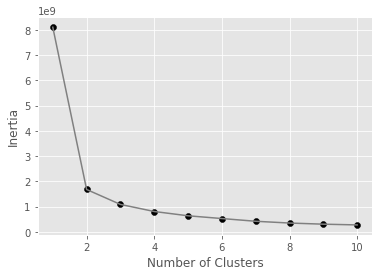

In [27]:
finding_elbow(df_prune, 10)

##### n_cluster = 2 seems to be most reasonable

In [34]:
df_prune.drop('IsAnomaly', axis = 1, inplace=True)

### Fitting Pre-Engineered dataset

In [53]:
model = KMeans(n_clusters=2)
model.fit(df_prune)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [54]:
clusters = pd.DataFrame(model.cluster_centers_)
clusters.columns  = list(df_prune.columns)

In [55]:
clusters

,Severity,LocationLat,LocationLng,Duration,StartMonth,StartDay,StartHour,StartMinute
0,1.78,47.49,-121.96,53.82,6.84,15.51,12.88,29.98
1,2.00,47.48,-122.18,18443.05,5.16,10.00,11.47,32.89


In [56]:
lab = pd.DataFrame(model.labels_)

In [57]:
lab[0].value_counts()

0    558762
1        19
Name: 0, dtype: int64

### Fitting Post-Engineered dataset

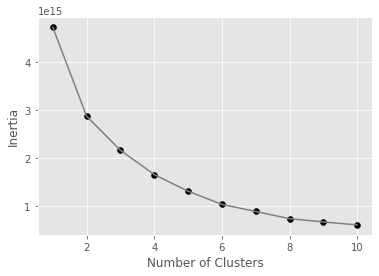

In [58]:
finding_elbow(classi_all, 10)

In [59]:
model = KMeans(n_clusters=2)
model.fit(classi_all)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [60]:
clusters = pd.DataFrame(model.cluster_centers_)
clusters.columns  = list(classi_all.columns)

In [61]:
clusters

,LocationLat^1,Severity^1 x LocationLat^1,Severity^1 x LocationLng^1,Severity^1 x Density(/sqmi)^1,Severity^1 x isWeekday^1,LocationLat^1 x LocationLng^1,LocationLat^1 x ZipCode^1,LocationLat^1 x Density(/sqmi)^1,LocationLat^1 x isWeekday^1,LocationLat^1 x SecondHalfHour^1,...,LocationLng^1 x Density(/sqmi)^1,LocationLng^1 x Mon^1,LocationLng^1 x Noon(12-18)^1,ZipCode^1 x Mon^1,Density(/sqmi)^1 x Mon^1,Density(/sqmi)^1 x Noon(12-18)^1,Mon^1 x Autum^1,Mon^1 x Morning(6-12)^1,Spring^1 x Morning(6-12)^1,Duration
0,47.51,84.91,-218.34,1093.05,1.50,-5805.07,4667022.75,28645.95,39.86,23.43,...,-73690.79,-14.24,-30.34,11453.24,66.48,166.44,0.03,0.01,0.01,55.11
1,47.16,81.14,-203.31,211.60,1.39,-5580.00,4675873.67,5215.86,38.42,23.33,...,-12947.86,-15.61,-29.02,13072.87,13.17,24.73,0.03,0.02,0.06,43.78


In [62]:
lab = pd.DataFrame(model.labels_)

In [63]:
lab[0].value_counts()

0    420918
1     25079
Name: 0, dtype: int64

## Isolation Forest

### Fitting Pre-Engineered dataset

In [155]:
from sklearn.ensemble import IsolationForest

In [160]:
df_enc_all= pd.read_csv('./data/classi_/df_enc_all.csv')

In [161]:
df_enc_all.head(5)

,Severity,LocationLat,LocationLng,ZipCode,Duration,Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years),Density(/sqmi),isWeekday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Spring,Summer,Autum,Winter,Morning(6-12),Noon(12-18),Night(18-24),midNight(24-6),firstHalfHour,SecondHalfHour,StartTime(UTC)
0,1,47.01,-122.91,98501,80,39.10,335.30,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,2016-11-30 23:35:00
1,2,47.61,-122.33,98104,12,36.90,870.90,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,2016-12-01 00:52:00
2,1,47.96,-122.20,98203,18,38.00,334.80,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,2016-12-01 01:08:00
3,1,47.56,-122.19,98006,22,36.90,870.90,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,2016-12-01 01:02:00
4,1,47.62,-122.33,98101,12,36.90,870.90,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,2016-12-01 01:19:00


In [273]:
df_enc_all.columns

Index(['Severity', 'LocationLat', 'LocationLng', 'ZipCode', 'Duration',
       'Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years)',
       'Density(/sqmi)', 'isWeekday', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Sun', 'Spring', 'Summer', 'Autum', 'Winter', 'Morning(6-12)',
       'Noon(12-18)', 'Night(18-24)', 'midNight(24-6)', 'firstHalfHour',
       'SecondHalfHour', 'StartTime(UTC)'],
      dtype='object')

In [163]:
clf = IsolationForest(random_state=42, n_jobs=2,contamination = 0.05).fit(df_enc_all.drop('StartTime(UTC)', axis=1))

In [165]:
pred = clf.predict(df_enc_all.drop('StartTime(UTC)', axis=1))
preds_df = pd.DataFrame(pred)
preds_df[0].value_counts()

 1    529623
-1     27875
Name: 0, dtype: int64

In [172]:
de_enc_pred = df_enc_all.copy()
de_enc_pred['isNormal'] = pred

enc_nor = de_enc_pred[de_enc_pred['isNormal'] == 1]
enc_ano = de_enc_pred[de_enc_pred['isNormal'] == -1]

In [196]:
nor_grp

,StartTime(UTC),LocationLat,LocationLng,Duration,Density(/sqmi),Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years),isWeekday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Spring,Summer,Autum,Winter,Morning(6-12),Noon(12-18),Night(18-24),midNight(24-6),firstHalfHour,SecondHalfHour
0,2016-08-01 00:04:00,47.59,-120.67,14.00,24.60,39.90,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00
1,2016-08-01 00:07:00,47.50,-122.19,11.00,870.90,36.90,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520516,2019-12-31 22:56:00,47.59,-122.32,45.00,870.90,36.90,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00
520517,2019-12-31 22:58:00,47.20,-122.30,44.00,449.90,36.30,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00


In [198]:
nor_grp = enc_nor.groupby(['StartTime(UTC)','ZipCode'])[['Duration', 'Density(/sqmi)', 'Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years)', 'isWeekday', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Spring', 'Summer', 'Autum','Winter', 'Morning(6-12)', 'Noon(12-18)', 'Night(18-24)', 'midNight(24-6)', 'firstHalfHour', 'SecondHalfHour']].mean().reset_index()

In [292]:
nor_grp_avg = nor_grp.describe().loc[['mean']]
nor_grp_avg.rename({'mean': 'nor_mean'},inplace=True)
nor_grp_avg

,ZipCode,Duration,Density(/sqmi),Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years),isWeekday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Spring,Summer,Autum,Winter,Morning(6-12),Noon(12-18),Night(18-24),midNight(24-6),firstHalfHour,SecondHalfHour
nor_mean,98253.08,51.26,593.55,37.20,0.85,0.12,0.17,0.18,0.19,0.19,0.11,0.04,0.22,0.23,0.27,0.28,0.03,0.25,0.40,0.32,0.51,0.49


In [283]:
ano_grp = enc_ano.groupby(['StartTime(UTC)','ZipCode'])[['Duration', 'Density(/sqmi)', 'Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years)', 'isWeekday', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Spring', 'Summer', 'Autum','Winter', 'Morning(6-12)', 'Noon(12-18)', 'Night(18-24)', 'midNight(24-6)', 'firstHalfHour', 'SecondHalfHour']].mean().reset_index()

In [294]:
ano_grp_avg = ano_grp.describe().loc[['mean']]
ano_grp_avg.rename({'mean': 'ano_mean'},inplace=True)
ano_grp_avg

,ZipCode,Duration,Density(/sqmi),Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years),isWeekday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Spring,Summer,Autum,Winter,Morning(6-12),Noon(12-18),Night(18-24),midNight(24-6),firstHalfHour,SecondHalfHour
ano_mean,98910.79,52.12,122.75,38.16,0.52,0.13,0.10,0.11,0.10,0.08,0.18,0.31,0.30,0.24,0.23,0.23,0.35,0.22,0.25,0.19,0.51,0.49


In [307]:
nor_vs_ano_pre = nor_grp_avg.append(ano_grp_avg)
nor_vs_ano_pre.rename({'Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years)': 'avgAge'},axis = 1, inplace=True)

In [309]:
nor_vs_ano_pre_T = nor_vs_ano_pre.T
nor_vs_ano_pre_T['diff'] = abs(nor_vs_ano_pre_T['ano_mean'] - nor_vs_ano_pre_T['nor_mean'])
nor_vs_ano_pre_T['diffPercent'] = abs(nor_vs_ano_pre_T['ano_mean'] - nor_vs_ano_pre_T['nor_mean'])/nor_vs_ano_pre_T['nor_mean']*100

In [310]:
nor_vs_ano_pre_T.head(22)

,nor_mean,ano_mean,diff,diffPercent
ZipCode,98253.08,98910.79,657.71,0.67
Duration,51.26,52.12,0.86,1.67
Density(/sqmi),593.55,122.75,470.80,79.32
avgAge,37.20,38.16,0.96,2.58
isWeekday,0.85,0.52,0.34,39.52
Mon,0.12,0.13,0.01,12.62
Tue,0.17,0.10,0.07,43.24
Wed,0.18,0.11,0.08,41.19
Thu,0.19,0.10,0.09,48.09
Fri,0.19,0.08,0.11,57.98


In [205]:
def Mon(x):
    return x.split(" ")[0].split('-')[1]
def Day(x):
    return x.split(" ")[0].split('-')[2]
def Hour(x):
    return x.split(" ")[1].split(':')[0]

de_enc_pred['StartMonth'] = de_enc_pred['StartTime(UTC)'].apply(lambda x: Mon(x)).astype(int)
de_enc_pred['StartDay'] = de_enc_pred['StartTime(UTC)'].apply(lambda x: Day(x)).astype(int)
de_enc_pred['StartHour'] = de_enc_pred['StartTime(UTC)'].apply(lambda x: Hour(x)).astype(int)

In [216]:
de_enc_pred_grp = de_enc_pred.groupby(['ZipCode', 'StartMonth', 'StartDay', 'StartHour'])[['Duration', 'Density(/sqmi)', 'Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years)', 'isWeekday', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Spring', 'Summer', 'Autum','Winter', 'Morning(6-12)', 'Noon(12-18)', 'Night(18-24)', 'midNight(24-6)', 'firstHalfHour', 'SecondHalfHour', 'isNormal']].mean().reset_index()

In [264]:
df_temp = de_enc_pred.groupby(['ZipCode', 'StartMonth', 'StartDay', 'StartHour'])[['isNormal']].nunique()

In [265]:
df_temp[df_temp['isNormal'] == 2]

isNormal
ZipCode StartMonth StartDay StartHour          
98003   2          9        7                 2
                            8                 2
98004   12         15       23                2
98006   4          23       3                 2
98012   11         4        14                2
...                                         ...
99362   9          4        16                2
        12         25       1                 2
99371   7          17       18                2
                            19                2
                   22       22                2

[2658 rows x 1 columns]

In [275]:
to_show = de_enc_pred[(de_enc_pred['ZipCode'] == 98003) & 
                (de_enc_pred['StartMonth'] == 2) & 
                (de_enc_pred['StartDay'] == 9) & 
                (de_enc_pred['StartHour'] == 7)]
to_show

,Severity,LocationLat,LocationLng,ZipCode,Duration,Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years),Density(/sqmi),isWeekday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Spring,Summer,Autum,Winter,Morning(6-12),Noon(12-18),Night(18-24),midNight(24-6),firstHalfHour,SecondHalfHour,StartTime(UTC),isNormal,StartMonth,StartDay,StartHour
271807,1,47.29,-122.31,98003,41,36.90,870.90,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,2019-02-09 07:33:00,1,2,9,7
271808,1,47.34,-122.29,98003,41,36.90,870.90,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,2019-02-09 07:34:00,1,2,9,7
271828,3,47.29,-122.30,98003,47,36.90,870.90,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,2019-02-09 07:43:00,-1,2,9,7


In [280]:
to_show[['LocationLat', 'LocationLng', 'ZipCode', 'Density(/sqmi)','StartTime(UTC)', 'Severity', 'Duration', 'isNormal']]

,LocationLat,LocationLng,ZipCode,Density(/sqmi),StartTime(UTC),Severity,Duration,isNormal
271807,47.29,-122.31,98003,870.90,2019-02-09 07:33:00,1,41,1
271808,47.34,-122.29,98003,870.90,2019-02-09 07:34:00,1,41,1
271828,47.29,-122.30,98003,870.90,2019-02-09 07:43:00,3,47,-1


In [270]:
de_enc_pred[(de_enc_pred['ZipCode'] == 99371) & 
                (de_enc_pred['StartMonth'] == 7) & 
                (de_enc_pred['StartDay'] == 17) & 
                (de_enc_pred['StartHour'] == 18)]

,Severity,LocationLat,LocationLng,ZipCode,Duration,Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years),Density(/sqmi),isWeekday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Spring,Summer,Autum,Winter,Morning(6-12),Noon(12-18),Night(18-24),midNight(24-6),firstHalfHour,SecondHalfHour,StartTime(UTC),isNormal,StartMonth,StartDay,StartHour
183653,1,46.74,-118.23,99371,50,28.60,9.80,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,2019-07-17 18:25:00,-1,7,17,18
183654,2,46.75,-118.28,99371,42,28.60,9.80,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,2019-07-17 18:37:00,1,7,17,18
183655,1,46.74,-118.23,99371,56,28.60,9.80,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,2019-07-17 18:43:00,1,7,17,18


In [256]:
zip_list = list(de_enc_pred_grp['ZipCode'].unique())
mon_list = list(de_enc_pred_grp['StartMonth'].unique())
day_list = list(de_enc_pred_grp['StartDay'].unique())
hr_list = list(de_enc_pred_grp['StartHour'].unique())

In [261]:
for zipc in zip_list:
    print (zipc)
    for mon in mon_list:
        for day in day_list:
            for hr in hr_list:

                if len(de_enc_pred_grp.loc[(de_enc_pred_grp['ZipCode'] == zipc) & 
                                    (de_enc_pred_grp['StartMonth'] == mon) & 
                                    (de_enc_pred_grp['StartDay'] == day) &
                                    (de_enc_pred_grp['StartHour'] == hr), 'isNormal']) >= 2:
                    print (de_enc_pred_grp.loc[(de_enc_pred_grp['ZipCode'] == zipc) & 
                                    (de_enc_pred_grp['StartMonth'] == mon) & 
                                    (de_enc_pred_grp['StartDay'] == day) &
                                    (de_enc_pred_grp['StartHour'] == hr), 'isNormal'])
                    print ("zipc: " , zipc) 
                    print ("mon: " , mon) 
                    print ("day: " , day) 
                    print ("hr: " , hr) 

98001
98002
98003
98004
98005
98006
98007
98008
98010
98011
98012
98014
98019
98020
98021
98022
98023
98024
98026
98027
98028
98029
98030
98031
98032
98033
98034
98036
98037
98038
98039
98040
98042
98043
98045
98047
98050
98051
98052
98053
98055
98056
98057
98058
98059
98065
98070
98072
98074
98075
98077
98087
98092
98101
98102
98103
98104
98105
98106
98107
98108
98109
98110
98112
98115
98116
98117
98118
98119
98121
98122
98125
98126
98133
98134
98136
98144
98146
98148
98154
98155
98158
98164
98166
98168
98174
98177
98178
98188
98195
98198
98199
98201
98203
98204
98208
98220
98221
98223
98224
98225
98226
98229
98230
98232
98233
98236
98237
98239
98240
98241
98244
98247
98248
98249
98251
98252
98253
98257
98258
98260
98264
98266
98267
98270
98271
98272
98273
98274
98275
98276
98277
98281
98282
98283
98284
98288
98290
98292
98294
98295
98296
98304
98305
98310
98311
98312
98320
98321
98325
98326
98327
98328
98329
98330
98331
98332
98333
98335
98336
98337
98338
98339
98346
98349
98351
9835

In [260]:
de_enc_pred_grp.to_csv('./data/de_enc_pred_grp.csv', index=False)

In [272]:
# clf.pickle
with open("models/clf.pickle", "wb") as pfile:
    pickle.dump(clf, pfile)

### Fitting Post-Engineered dataset

In [72]:
clf = IsolationForest(random_state=42, n_jobs=2,contamination = 0.05).fit(classi_all)

In [86]:
pred = clf.predict(classi_all)

In [87]:
preds_df = pd.DataFrame(pred)

In [88]:
preds_df[0].value_counts()

 1    423697
-1     22300
Name: 0, dtype: int64

In [118]:
classi_all_pred = classi_all.copy()

In [119]:
classi_all_pred['isNormal'] = pred

In [120]:
df_nor = classi_all_pred[classi_all_pred['isNormal'] == 1]
df_ano = classi_all_pred[classi_all_pred['isNormal'] == -1]

In [153]:
df_nor.describe()

,LocationLat^1,Severity^1 x LocationLat^1,Severity^1 x LocationLng^1,Severity^1 x Density(/sqmi)^1,Severity^1 x isWeekday^1,LocationLat^1 x LocationLng^1,LocationLat^1 x ZipCode^1,LocationLat^1 x Density(/sqmi)^1,LocationLat^1 x isWeekday^1,LocationLat^1 x SecondHalfHour^1,LocationLng^1 x ZipCode^1,LocationLng^1 x Density(/sqmi)^1,LocationLng^1 x Mon^1,LocationLng^1 x Noon(12-18)^1,ZipCode^1 x Mon^1,Density(/sqmi)^1 x Mon^1,Density(/sqmi)^1 x Noon(12-18)^1,Mon^1 x Autum^1,Mon^1 x Morning(6-12)^1,Spring^1 x Morning(6-12)^1,Duration,isNormal
count,423697.00,423697.00,423697.00,423697.00,423697.00,423697.00,423697.00,423697.00,423697.00,423697.00,423697.00,423697.00,423697.00,423697.00,423697.00,423697.00,423697.00,423697.00,423697.00,423697.00,423697.00,423697.00
mean,47.50,83.70,-214.96,1052.41,1.48,-5794.30,4667787.77,27770.56,39.75,23.38,-11987763.57,-71396.52,-10.47,-28.88,8434.75,49.59,154.01,0.01,0.00,0.01,53.69,1.00
std,0.43,36.19,92.89,764.62,0.95,75.73,37618.05,15093.69,17.56,23.75,74341.99,38812.87,34.18,51.86,27527.19,186.79,314.66,0.11,0.04,0.11,45.71,0.00
min,45.56,45.56,-373.20,3.10,0.00,-6015.29,4494034.83,143.89,0.00,0.00,-12255650.56,-106690.07,-124.39,-124.40,0.00,0.00,0.00,0.00,0.00,0.00,10.00,1.00
25%,47.28,47.59,-244.69,449.90,1.00,-5832.72,4648520.33,16025.12,47.12,0.00,-12007245.27,-106480.72,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,41.00,1.00
50%,47.57,94.43,-244.24,870.90,1.00,-5811.00,4669620.02,41178.41,47.50,0.00,-12000004.94,-105787.11,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,43.00,1.00
75%,47.71,95.63,-122.24,1741.80,2.00,-5776.75,4683605.09,41446.10,47.68,47.56,-11978347.39,-40921.73,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,54.00,1.00
max,49.00,147.01,-117.04,2612.70,3.00,-5400.07,4858594.24,41637.35,49.00,49.00,-11589349.32,-363.55,-0.00,-0.00,99403.00,870.90,870.90,1.00,1.00,1.00,10483.00,1.00


In [154]:
df_ano.describe()

,LocationLat^1,Severity^1 x LocationLat^1,Severity^1 x LocationLng^1,Severity^1 x Density(/sqmi)^1,Severity^1 x isWeekday^1,LocationLat^1 x LocationLng^1,LocationLat^1 x ZipCode^1,LocationLat^1 x Density(/sqmi)^1,LocationLat^1 x isWeekday^1,LocationLat^1 x SecondHalfHour^1,LocationLng^1 x ZipCode^1,LocationLng^1 x Density(/sqmi)^1,LocationLng^1 x Mon^1,LocationLng^1 x Noon(12-18)^1,ZipCode^1 x Mon^1,Density(/sqmi)^1 x Mon^1,Density(/sqmi)^1 x Noon(12-18)^1,Mon^1 x Autum^1,Mon^1 x Morning(6-12)^1,Spring^1 x Morning(6-12)^1,Duration,isNormal
count,22300.00,22300.00,22300.00,22300.00,22300.00,22300.00,22300.00,22300.00,22300.00,22300.00,22300.00,22300.00,22300.00,22300.00,22300.00,22300.00,22300.00,22300.00,22300.00,22300.00,22300.00,22300.00
mean,47.34,103.54,-265.63,874.15,1.81,-5756.70,4662438.99,18934.71,40.30,24.31,-11973760.02,-48985.45,-87.24,-56.67,70625.06,327.43,243.26,0.40,0.09,0.12,69.38,-1.00
std,1.02,41.72,106.28,882.30,1.10,157.69,92326.62,16817.51,16.83,23.69,126647.12,43571.21,54.76,60.75,44319.27,372.72,352.11,0.49,0.29,0.33,500.13,0.00
min,45.56,45.56,-373.66,3.10,0.00,-6030.61,4494034.83,143.89,0.00,0.00,-12258025.13,-106688.39,-124.41,-124.55,0.00,0.00,0.00,0.00,0.00,0.00,10.00,-1.00
25%,46.66,47.69,-367.02,103.40,1.00,-5834.38,4614270.85,3977.61,45.86,0.00,-12058186.62,-106149.16,-122.32,-122.29,0.00,0.00,0.00,0.00,0.00,0.00,41.00,-1.00
50%,47.44,96.06,-245.35,667.90,2.00,-5782.25,4663457.18,15772.51,47.30,45.62,-12001406.15,-40859.33,-121.88,-0.00,98108.00,81.80,0.00,0.00,0.00,0.00,43.00,-1.00
75%,47.76,142.79,-122.55,1349.70,3.00,-5597.97,4709303.95,41261.55,47.65,47.49,-11941159.50,-9991.33,-0.00,-0.00,98516.00,870.90,667.90,1.00,0.00,0.00,54.00,-1.00
max,49.00,147.01,-117.04,2612.70,3.00,-5405.62,4855598.11,41633.13,49.00,49.00,-11589414.28,-363.55,-0.00,-0.00,99403.00,870.90,870.90,1.00,1.00,1.00,24615.00,-1.00


In [121]:
df_nor_avg = df_nor.describe().loc[['mean']]
df_nor_avg.rename({'mean': 'nor_mean'},inplace=True)
df_nor_avg

,LocationLat^1,Severity^1 x LocationLat^1,Severity^1 x LocationLng^1,Severity^1 x Density(/sqmi)^1,Severity^1 x isWeekday^1,LocationLat^1 x LocationLng^1,LocationLat^1 x ZipCode^1,LocationLat^1 x Density(/sqmi)^1,LocationLat^1 x isWeekday^1,LocationLat^1 x SecondHalfHour^1,LocationLng^1 x ZipCode^1,LocationLng^1 x Density(/sqmi)^1,LocationLng^1 x Mon^1,LocationLng^1 x Noon(12-18)^1,ZipCode^1 x Mon^1,Density(/sqmi)^1 x Mon^1,Density(/sqmi)^1 x Noon(12-18)^1,Mon^1 x Autum^1,Mon^1 x Morning(6-12)^1,Spring^1 x Morning(6-12)^1,Duration,isNormal
nor_mean,47.50,83.70,-214.96,1052.41,1.48,-5794.30,4667787.77,27770.56,39.75,23.38,-11987763.57,-71396.52,-10.47,-28.88,8434.75,49.59,154.01,0.01,0.00,0.01,53.69,1.00


In [122]:
df_ano_avg = df_ano.describe().loc[['mean']]
df_ano_avg.rename({'mean': 'ano_mean'},inplace=True)
df_ano_avg

,LocationLat^1,Severity^1 x LocationLat^1,Severity^1 x LocationLng^1,Severity^1 x Density(/sqmi)^1,Severity^1 x isWeekday^1,LocationLat^1 x LocationLng^1,LocationLat^1 x ZipCode^1,LocationLat^1 x Density(/sqmi)^1,LocationLat^1 x isWeekday^1,LocationLat^1 x SecondHalfHour^1,LocationLng^1 x ZipCode^1,LocationLng^1 x Density(/sqmi)^1,LocationLng^1 x Mon^1,LocationLng^1 x Noon(12-18)^1,ZipCode^1 x Mon^1,Density(/sqmi)^1 x Mon^1,Density(/sqmi)^1 x Noon(12-18)^1,Mon^1 x Autum^1,Mon^1 x Morning(6-12)^1,Spring^1 x Morning(6-12)^1,Duration,isNormal
ano_mean,47.34,103.54,-265.63,874.15,1.81,-5756.70,4662438.99,18934.71,40.30,24.31,-11973760.02,-48985.45,-87.24,-56.67,70625.06,327.43,243.26,0.40,0.09,0.12,69.38,-1.00


In [132]:
nor_vs_ano = df_nor_avg.append(df_ano_avg)
nor_vs_ano

,LocationLat^1,Severity^1 x LocationLat^1,Severity^1 x LocationLng^1,Severity^1 x Density(/sqmi)^1,Severity^1 x isWeekday^1,LocationLat^1 x LocationLng^1,LocationLat^1 x ZipCode^1,LocationLat^1 x Density(/sqmi)^1,LocationLat^1 x isWeekday^1,LocationLat^1 x SecondHalfHour^1,LocationLng^1 x ZipCode^1,LocationLng^1 x Density(/sqmi)^1,LocationLng^1 x Mon^1,LocationLng^1 x Noon(12-18)^1,ZipCode^1 x Mon^1,Density(/sqmi)^1 x Mon^1,Density(/sqmi)^1 x Noon(12-18)^1,Mon^1 x Autum^1,Mon^1 x Morning(6-12)^1,Spring^1 x Morning(6-12)^1,Duration,isNormal
nor_mean,47.50,83.70,-214.96,1052.41,1.48,-5794.30,4667787.77,27770.56,39.75,23.38,-11987763.57,-71396.52,-10.47,-28.88,8434.75,49.59,154.01,0.01,0.00,0.01,53.69,1.00
ano_mean,47.34,103.54,-265.63,874.15,1.81,-5756.70,4662438.99,18934.71,40.30,24.31,-11973760.02,-48985.45,-87.24,-56.67,70625.06,327.43,243.26,0.40,0.09,0.12,69.38,-1.00


In [137]:
difference = nor_vs_ano.diff().loc[['ano_mean']]
difference.rename({'ano_mean': 'difference'},inplace=True)

In [143]:
nor_vs_ano = nor_vs_ano.append(difference)

In [146]:
nor_vs_ano_T = nor_vs_ano.T
nor_vs_ano_T

,nor_mean,ano_mean,difference
LocationLat^1,47.50,47.34,-0.15
Severity^1 x LocationLat^1,83.70,103.54,19.83
Severity^1 x LocationLng^1,-214.96,-265.63,-50.68
Severity^1 x Density(/sqmi)^1,1052.41,874.15,-178.27
Severity^1 x isWeekday^1,1.48,1.81,0.33
LocationLat^1 x LocationLng^1,-5794.30,-5756.70,37.59
LocationLat^1 x ZipCode^1,4667787.77,4662438.99,-5348.78
LocationLat^1 x Density(/sqmi)^1,27770.56,18934.71,-8835.85
LocationLat^1 x isWeekday^1,39.75,40.30,0.55
LocationLat^1 x SecondHalfHour^1,23.38,24.31,0.94


In [149]:
nor_vs_ano_T['percentDiff'] = abs((nor_vs_ano_T['ano_mean'] - nor_vs_ano_T['nor_mean'])/nor_vs_ano_T['nor_mean'] * 100)

In [151]:
nor_vs_ano_T[nor_vs_ano_T['percentDiff'] > 20]

,nor_mean,ano_mean,difference,percentDiff
Severity^1 x LocationLat^1,83.70,103.54,19.83,23.70
Severity^1 x LocationLng^1,-214.96,-265.63,-50.68,23.57
Severity^1 x isWeekday^1,1.48,1.81,0.33,22.51
LocationLat^1 x Density(/sqmi)^1,27770.56,18934.71,-8835.85,31.82
LocationLng^1 x Density(/sqmi)^1,-71396.52,-48985.45,22411.07,31.39
LocationLng^1 x Mon^1,-10.47,-87.24,-76.76,732.84
LocationLng^1 x Noon(12-18)^1,-28.88,-56.67,-27.79,96.24
ZipCode^1 x Mon^1,8434.75,70625.06,62190.31,737.31
Density(/sqmi)^1 x Mon^1,49.59,327.43,277.83,560.21
Density(/sqmi)^1 x Noon(12-18)^1,154.01,243.26,89.25,57.95


##### Hard to interpret without actual time data

## T-SNE (Abandoned, left in for future reference)

In [32]:
from sklearn.manifold import TSNE

In [33]:
tsne = TSNE(learning_rate=100)
transformed = tsne.fit_transform(df_prune)

KeyboardInterrupt: 

In [ ]:
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.scatter(x_axis, y_axis, c=df_label)
plt.show()

## DBSCAN  (Abandoned, left in for future reference)

In [39]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn import metrics

In [59]:
# Declaring Model
dbscan = DBSCAN(eps=10)

# Fitting
dbscan.fit(df_prune)

KeyboardInterrupt: 

In [ ]:
db_labels = pd.DataFrame(dbscan.labels_)
db_labels[0].value_counts()

In [51]:
# Transoring Using PCA
pca = PCA(n_components=1).fit(df_prune)
pca_2d = pca.transform(df_prune)

In [52]:
pca.explained_variance_ratio_

array([0.96875416])

In [53]:
pca.components_

array([[ 0.00020605,  0.00002513, -0.00028306,  0.99999136,  0.00069843,
         0.00041969,  0.00405792,  0.0001551 ]])

In [46]:
for i in range(0, pca_2d.shape[0]):
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='r', marker='+')
    elif dbscan.labels_[i] == 1:
        c2 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='g', marker='o')
    elif dbscan.labels_[i] == -1:
        c3 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='b', marker='*')

plt.legend([c1, c2, c3 ], ['Cluster 1', 'Cluster 2', 'Noise'])
plt.title('DBSCAN finds 2 clusters and Noise')
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000293EF8403A8> (for post_execute):


KeyboardInterrupt: 

In [ ]:
labels_true = np.where(df_prune['Duration'] >= 123, 1, 0)
X = StandardScaler().fit_transform(df_prune)

In [47]:
# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.5, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################

Estimated number of clusters: 374
Estimated number of noise points: 73635


NameError: name 'metrics' is not defined

In [ ]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## OPTIC  (Abandoned, left in for future reference)

In [48]:
from sklearn.cluster import OPTICS

In [50]:
clustering = OPTICS(min_samples=10, cluster_method='dbscan').fit(X)

KeyboardInterrupt: 

## Autoencoder  (Abandoned, left in for future reference)

In [60]:
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import regularizers

Using TensorFlow backend.


In [61]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
train, test = train_test_split(df_prune, test_size=0.2)

In [ ]:
X_train=train.copy()
X_test = test.copy()

# Conclusion

### Isolation Forest works the best.